In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
from MotionBERT.common_import import *
from hpe_library.spin_utils import *
user = getpass.getuser()
root_3dpw_original = f'/home/{user}/Datasets/HAAI/3DPW/original'

train_root = root_3dpw_original + '/sequenceFiles/sequenceFiles/train'
test_root = root_3dpw_original + '/sequenceFiles/sequenceFiles/test'
valid_root = root_3dpw_original + '/sequenceFiles/sequenceFiles/validation'
img_root = root_3dpw_original + '/imageFiles'

assert os.path.exists(root_3dpw_original), "3DPW not found"
assert os.path.exists(train_root), "train root not found"
assert os.path.exists(test_root), "test root not found"
assert os.path.exists(valid_root), "valid root not found"
assert os.path.exists(img_root), "img root not found"

config = spin_config

In [ ]:
# Define command-line arguments
parser = argparse.ArgumentParser()
parser.add_argument('--checkpoint', default=None, help='Path to network checkpoint')
parser.add_argument('--dataset', default='3dpw', choices=['h36m-p1', 'h36m-p2', 'lsp', '3dpw', 'mpi-inf-3dhp'], help='Choose evaluation dataset')
parser.add_argument('--log_freq', default=50, type=int, help='Frequency of printing intermediate results')
parser.add_argument('--batch_size', default=1, help='Batch size for testing')
parser.add_argument('--shuffle', default=False, action='store_true', help='Shuffle data')
parser.add_argument('--num_workers', default=8, type=int, help='Number of processes for data loading')
parser.add_argument('--result_file', default=None, help='If set, save detections to a .npz file')
args = parser.parse_args([])
args

Namespace(checkpoint=None, dataset='3dpw', log_freq=50, batch_size=1, shuffle=False, num_workers=8, result_file=None)

In [ ]:
spin_3dpw = np.load(config.DATASET_FILES[False][args.dataset])
spin_3dpw.files

['imgname', 'center', 'scale', 'pose', 'shape', 'gender']

In [4]:
# betas <class 'list'> (2, 300)
# betas_clothed <class 'list'> (2, 300)
# campose_valid <class 'list'> (2, 1403)
# genders <class 'list'> (2,)
# jointPositions <class 'list'> (2, 1403, 72)
# poses <class 'list'> (2, 1403, 72)
# poses2d <class 'list'> (2, 1403, 3, 18)
# poses_60Hz <class 'list'> (2, 2807, 72)
# trans <class 'list'> (2, 1403, 3)
# trans_60Hz <class 'list'> (2, 2807, 3)
# v_template_clothed <class 'list'> (2, 6890, 3)

# cam_intrinsics <class 'numpy.ndarray'> (3, 3)
# cam_poses <class 'numpy.ndarray'> (1403, 4, 4)
# img_frame_ids <class 'numpy.ndarray'> (1403,)
# sequence <class 'numpy.str_'> ()
# texture_maps <class 'list'> (0,)

### seq_list, source_list, cam_params, img_paths

In [34]:
train_seq_list, test_seq_list, valid_seq_list = get_3dpw_seq_list()
source_list = get_3dpw_source_list()
cam_params = get_3dpw_cam_params()
img_paths = get_3dpw_img_paths()

load 3dpw source_list from /home/hrai/codes/MotionBERT/custom_codes/dataset_generation/3dpw/3dpw-source_list.pkl
load 3dpw cam_params from /home/hrai/codes/MotionBERT/custom_codes/dataset_generation/3dpw/3dpw-cam_params.pkl
load 3dpw img_paths from /home/hrai/codes/MotionBERT/custom_codes/dataset_generation/3dpw/3dpw-img_paths.pkl


### get h36m pose from SPML regressor

In [7]:
# set device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# craete SMPL model
smpl_neutral = SMPL(config.SMPL_MODEL_DIR, create_transl=False).to(device)
smpl_male = SMPL(config.SMPL_MODEL_DIR, gender='male', create_transl=False).to(device)
smpl_female = SMPL(config.SMPL_MODEL_DIR, gender='female', create_transl=False).to(device)
# load SMPL regressor
J_regressor = torch.from_numpy(np.load(config.JOINT_REGRESSOR_H36M)).float() # torch.Size([17, 6890])
# build dataset
dataset = BaseDataset(None, args.dataset, is_train=False)
data_loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=args.shuffle, num_workers=args.num_workers)
joint_mapper_gt = spin_constants.J24_TO_J17
joint_mapper_h36m = spin_constants.H36M_TO_J17
print(dataset[0].keys())

# load pkl data
source = source_list[0]
data_type = source.split('_')[0]
seq_name = source.removeprefix(f"{data_type}_")[:-2]

pkl_data = load_pkl_3dpw(data_type, seq_name)
subject_id = 0
num_people = len(pkl_data['poses'])
num_frames = len(pkl_data['poses'][0])
smpl_poses = torch.from_numpy(np.array(pkl_data['poses'])).to(device)
smpl_betas = torch.from_numpy(np.array(pkl_data['betas'])).to(device)
gender = pkl_data['genders']

print(f"data_type: {data_type}, seq_name: {seq_name}, num_frames: {num_frames} num_people: {num_people}, gender: {gender}")
print(f"smpl_poses: {smpl_poses.shape}, smpl_betas: {smpl_betas.shape}")

dict_keys(['img', 'pose', 'betas', 'imgname', 'pose_3d', 'keypoints', 'has_smpl', 'has_pose_3d', 'scale', 'center', 'orig_shape', 'is_flipped', 'rot_angle', 'gender', 'sample_index', 'dataset_name', 'maskname', 'partname'])
data_type: train, seq_name: outdoors_slalom_00, num_frames: 333 num_people: 1, gender: ['f']
smpl_poses: torch.Size([1, 333, 72]), smpl_betas: torch.Size([1, 300])


In [8]:
for step, batch in enumerate(tqdm(data_loader, desc='Eval', total=len(data_loader))):
    print(batch.keys())
    gt_pose = batch['pose'].to(device) # (B, 72)
    gt_betas = batch['betas'].to(device) # (B, 10)
    gender = batch['gender'].to(device)
    imgname = batch['imgname']
    print(imgname)
    print(gender)
    J_regressor_batch = J_regressor[None, :].expand(args.batch_size, -1, -1).to(device)
    #gt_vertices = smpl_neutral(betas=gt_betas, body_pose=gt_pose[:, 3:], global_orient=gt_pose[:, :3]).vertices
    gt_vertices = smpl_male(global_orient=gt_pose[:,:3], body_pose=gt_pose[:,3:], betas=gt_betas).vertices # (B, 6890, 3)
    gt_vertices_female = smpl_female(global_orient=gt_pose[:,:3], body_pose=gt_pose[:,3:], betas=gt_betas).vertices
    gt_vertices[gender==1, :, :] = gt_vertices_female[gender==1, :, :]
    gt_keypoints_3d = torch.matmul(J_regressor_batch, gt_vertices) # (B, 17, 3)
    gt_pelvis = gt_keypoints_3d[:, [0],:].clone() # (B, 1, 3)
    break

Eval:   0%|          | 0/35515 [00:00<?, ?it/s]

dict_keys(['img', 'pose', 'betas', 'imgname', 'pose_3d', 'keypoints', 'has_smpl', 'has_pose_3d', 'scale', 'center', 'orig_shape', 'is_flipped', 'rot_angle', 'gender', 'sample_index', 'dataset_name', 'maskname', 'partname'])
['/home/hrai/Datasets/HAAI/3DPW/original/imageFiles/downtown_enterShop_00/image_00000.jpg']
tensor([0], device='cuda:0', dtype=torch.int32)


Eval:   0%|          | 0/35515 [00:01<?, ?it/s]


downtown_enterShop_00 test


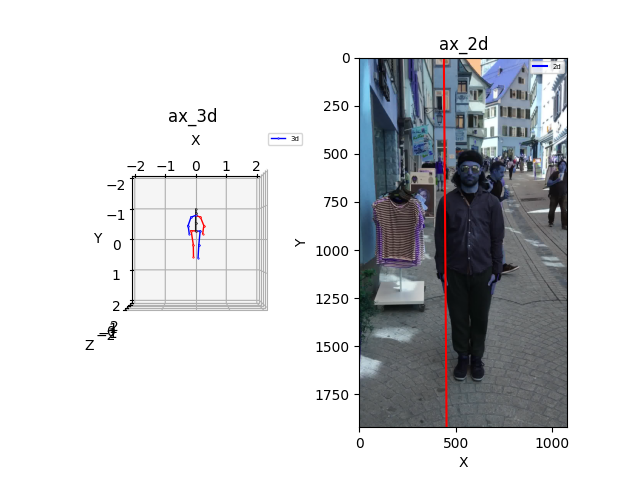

In [9]:
seq_name = imgname[0].split('/')[-2]
data_type = verify_3dpw_seq_datatype(seq_name)
print(seq_name, data_type)
pose3d_gt = gt_keypoints_3d.detach().cpu().numpy()
img = cv2.imread(imgname[0])
W, H = img.shape[1], img.shape[0]
cam_param = cam_params[data_type][seq_name]
intrinsic = cam_param['intrinsic']
pose2d_gt = projection(pose3d_gt, intrinsic)

configs = {
    'ax_3d': {'type': '3d', 'loc': 121, 'mode': 'cam'},
    'ax_2d': {'type': '2d', 'loc': 122, 'W': W, 'H': H},
}
fig, axs = generate_axes(0, configs, fig_title='')
plot_pose_setting = [
    ('ax_3d', pose3d_gt, {'color': '', 'label': '3d', 'dataset': 'h36m'}),
    ('ax_2d', pose2d_gt, {'color': '', 'label': '2d', 'dataset': 'h36m'}),
    ('ax_2d', None, {'img': img}),
]
general_plot_func(axs, configs, plot_pose_setting, 0)
plt.show()

### world_3d, cam_3d

In [45]:
def get_3dpw_jointPosition_world_3d(overwrite=False):
    from hpe_library.my_utils import savepkl, readpkl, load_pkl_3dpw, smpl2h36m, get_3dpw_source_list
    user = getpass.getuser()
    save_path_jointPosition_world_3d = f'/home/{user}/codes/MotionBERT/custom_codes/dataset_generation/3dpw/3dpw-jointPosition_world_3d.pkl'
    if os.path.exists(save_path_jointPosition_world_3d) and not overwrite:
        print(f"load 3dpw jointPosition_world_3ds from {save_path_jointPosition_world_3d}")
        jointPosition_world_3ds = readpkl(save_path_jointPosition_world_3d)
    else:
        source_list = get_3dpw_source_list()
        jointPosition_world_3ds = {}
        for source in source_list:# tqdm(source_list, desc='generate jointPosition_world_3d'):
            data_type = source.split('_')[0]
            seq_name = source.removeprefix(f"{data_type}_")[:-2]
            sub_id = int(source.split('_')[-1])
            print(data_type, seq_name, sub_id)
            if data_type not in jointPosition_world_3ds: jointPosition_world_3ds[data_type] = {}
            if seq_name not in jointPosition_world_3ds: jointPosition_world_3ds[data_type][seq_name] = {}
            data = load_pkl_3dpw(data_type, seq_name)
            jointPositions = data['jointPositions'][sub_id].copy()
            valid = data['campose_valid'][sub_id].astype(bool)
            world_3d = smpl2h36m(jointPositions.reshape(-1, 24, 3))[valid]
            #print(world_3d.shape)
            jointPosition_world_3ds[data_type][seq_name][sub_id] = world_3d
        savepkl(jointPosition_world_3ds, save_path_jointPosition_world_3d)
    return jointPosition_world_3ds

def get_3dpw_jointPosition_cam_3d(overwrite=False):
    from hpe_library.my_utils import savepkl, readpkl, load_pkl_3dpw, smpl2h36m, get_3dpw_source_list, get_3dpw_cam_params
    user = getpass.getuser()
    save_path_jointPosition_cam_3d = f'/home/{user}/codes/MotionBERT/custom_codes/dataset_generation/3dpw/3dpw-jointPosition_cam_3d.pkl'
    if os.path.exists(save_path_jointPosition_cam_3d) and not overwrite:
        print(f"load 3dpw jointPosition_cam_3ds from {save_path_jointPosition_cam_3d}")
        jointPosition_cam_3ds = readpkl(save_path_jointPosition_cam_3d)
    else:
        source_lsit = get_3dpw_source_list()
        cam_params = get_3dpw_cam_params()
        jointPosition_world_3ds = get_3dpw_jointPosition_world_3d()
        jointPosition_cam_3ds = {}
        for source in tqdm(source_list, desc='generate jointPosition_cam_3d'):
            data_type = source.split('_')[0]
            seq_name = source.removeprefix(f"{data_type}_")[:-2]
            sub_id = int(source.split('_')[-1])
            if data_type not in jointPosition_cam_3ds: jointPosition_cam_3ds[data_type] = {}
            if seq_name not in jointPosition_cam_3ds: jointPosition_cam_3ds[data_type][seq_name] = {}
            print(data_type, seq_name, sub_id)
            jointPosition_world_3d = jointPosition_world_3ds[data_type][seq_name][sub_id]
            #print(jointPosition_world_3d.shape)
            cam_param = cam_params[data_type][seq_name]
            intrinsic, W, H = cam_param['intrinsic'], cam_param['W'], cam_param['H']
            R = cam_param['R'] # (N, 3, 3)
            R_t = np.transpose(R, (0, 2, 1)) # (N, 3, 3)
            print(R_t.shape)
            t = cam_param['t'] # (N, 3)
            print(t.shape, jointPosition_world_3d.shape[1])
            jointPosition_cam_3d = np.einsum('ijk,ikl->ijl', jointPosition_world_3d, R_t) + t.reshape(-1, 1, 3).repeat(jointPosition_world_3d.shape[1], axis=1)
            jointPosition_cam_3ds[data_type][seq_name][sub_id] = jointPosition_cam_3d
        savepkl(jointPosition_cam_3ds, save_path_jointPosition_cam_3d)
    return jointPosition_cam_3ds

In [46]:
smpl_cam_3ds_hat = get_3dpw_smpl_cam_3d_hat()
jointPosition_world_3ds = get_3dpw_jointPosition_world_3d(overwrite=True)
jointPosition_cam_3ds = get_3dpw_jointPosition_cam_3d()

load 3dpw smpl_cam_3d_hat from /home/hrai/codes/MotionBERT/custom_codes/dataset_generation/3dpw/3dpw-smpl_cam_3d_hat.pkl
load 3dpw source_list from /home/hrai/codes/MotionBERT/custom_codes/dataset_generation/3dpw/3dpw-source_list.pkl
train outdoors_slalom_00 0
train courtyard_bodyScannerMotions_00 0
train courtyard_goodNews_00 0
train courtyard_goodNews_00 1
train courtyard_jacket_00 0
train courtyard_giveDirections_00 0
train courtyard_giveDirections_00 1
train outdoors_climbing_02 0
train courtyard_golf_00 0
train courtyard_arguing_00 0
train courtyard_arguing_00 1
train courtyard_basketball_00 0
train courtyard_basketball_00 1
train courtyard_laceShoe_00 0
train courtyard_captureSelfies_00 0
train courtyard_captureSelfies_00 1
train courtyard_dancing_01 0
train courtyard_dancing_01 1
train courtyard_backpack_00 0
train courtyard_relaxOnBench_01 0
train courtyard_relaxOnBench_00 0
train outdoors_slalom_01 0
train outdoors_climbing_01 0
train courtyard_capoeira_00 0
train courtyard_ca

generate jointPosition_cam_3d:   2%|▏         | 2/87 [00:00<00:00, 1205.09it/s]

train outdoors_slalom_00 0
(328, 3, 3)
(328, 3) 17
train courtyard_bodyScannerMotions_00 0
(1257, 3, 3)
(1257, 3) 17
train courtyard_goodNews_00 0


KeyError: 0

In [50]:
print(*jointPosition_world_3ds['train'].keys(), sep='\n')

outdoors_slalom_00
courtyard_bodyScannerMotions_00
courtyard_goodNews_00
courtyard_jacket_00
courtyard_giveDirections_00
outdoors_climbing_02
courtyard_golf_00
courtyard_arguing_00
courtyard_basketball_00
courtyard_laceShoe_00
courtyard_captureSelfies_00
courtyard_dancing_01
courtyard_backpack_00
courtyard_relaxOnBench_01
courtyard_relaxOnBench_00
outdoors_slalom_01
outdoors_climbing_01
courtyard_capoeira_00
courtyard_warmWelcome_00
courtyard_rangeOfMotions_00
outdoors_freestyle_00
outdoors_climbing_00
courtyard_shakeHands_00
courtyard_box_00


In [53]:
jointPosition_world_3ds['train']['outdoors_slalom_00'].keys()

dict_keys([0])

outdoors_slalom_00
smpl_cam_3d_pelvis: (333, 1, 3)


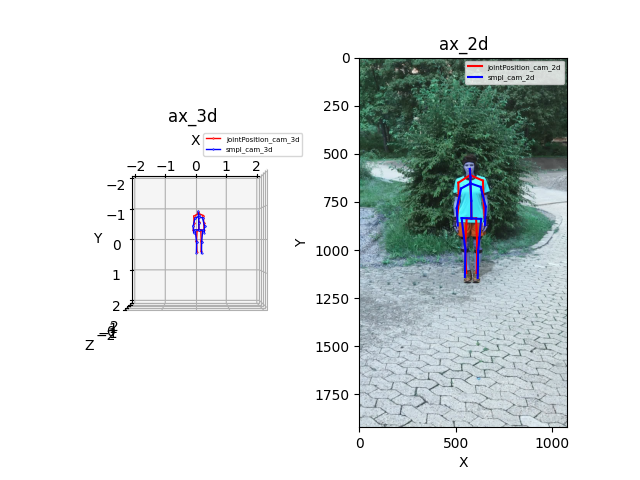

In [18]:
source = source_list[0]
data_type = source.split('_')[0]
seq_name = source.removeprefix(f"{data_type}_")[:-2]
sub_id = 0
img_path = img_paths[data_type][seq_name][sub_id]
print(seq_name)
cam_param = cam_params[data_type][seq_name]
intrinsic, W, H = cam_param['intrinsic'], cam_param['W'], cam_param['H']
R = cam_param['R'] # (N, 3, 3)
R_t = np.transpose(R, (0, 2, 1))
t = cam_param['t'] # (N, 3)

pkl_data = load_pkl_3dpw(data_type, seq_name)
jointPositions = pkl_data['jointPositions'][sub_id] # (N, 72)
valid = pkl_data['campose_valid'][sub_id].astype(bool)
trans = pkl_data['trans'][sub_id]
#trans = np.einsum('nij,nj->ni', R, trans) + t

smpl_world_3d = jointPositions.reshape(-1, 24, 3)
smpl_cam_3d = smpl2h36m(np.einsum('ijk,ikl->ijl', smpl_world_3d, R_t) + t.reshape(-1, 1, 3).repeat(24, axis=1))
smpl_img_2d = projection(smpl_cam_3d, intrinsic)

smpl_cam_3d_pelvis = smpl_cam_3d[:, [0], :]
print(f"smpl_cam_3d_pelvis: {smpl_cam_3d_pelvis.shape}")

cam_3d = get_3dpw_smpl_regressed_joint(data_type, seq_name, sub_id, J_regressor, smpl_male, smpl_female)
cam_3d_hat = cam_3d.copy() - cam_3d[:,0:1,:]
cam_3d = cam_3d_hat + smpl_cam_3d_pelvis[valid]
img_2d = projection(cam_3d, intrinsic)
#img_2d_hat = img_2d.copy() - img_2d[:,0:1,:]
#img_2d = img_2d_hat #+ centers[:,None,:]


frame_num = 0
img = cv2.imread(f'{root_3dpw_original}/{img_path[frame_num]}')

configs = {
    'ax_3d': {'type': '3d', 'loc': 121, 'mode': 'cam'},
    'ax_2d': {'type': '2d', 'loc': 122, 'W': W, 'H': H},
}
fig, axs = generate_axes(2, configs, fig_title='')
plot_pose_setting = [
    ('ax_3d', smpl_cam_3d, {'color': 'r', 'label': 'jointPosition_cam_3d', 'dataset': 'h36m'}),
    ('ax_2d', smpl_img_2d, {'color': 'r', 'label': 'jointPosition_cam_2d', 'dataset': 'h36m'}),
    ('ax_3d', cam_3d, {'color': 'b', 'label': 'smpl_cam_3d', 'dataset': 'h36m'}),
    ('ax_2d', img_2d, {'color': 'b', 'label': 'smpl_cam_2d', 'dataset': 'h36m', 'img': img}),
]
general_plot_func(axs, configs, plot_pose_setting, 0)
plt.show()

### Compare with poseaug 3dpw

In [19]:
# load poseaug 3dhp
poseaug_3dpw = np.load('/home/hrai/Datasets/HAAI/3DPW/poseaug/test_3dpw_gt.npz', allow_pickle=True)
pose3d_poseaug = poseaug_3dpw['pose3d']
pose2d_poseaug = poseaug_3dpw['pose2d']

In [20]:
frame_num = 0
target_pose = pose3d_poseaug[frame_num]
target_pose_hat = target_pose.copy() - target_pose[0]

In [22]:
target_frame = 0
target_pose = pose3d_poseaug[target_frame]
print(target_pose.shape)
#target_pose_hat = pose3d_poseaug[target_frame].copy() - pose3d_poseaug[target_frame, 0] # root-relative
closest_frame, closest_pose, closest_dist, closest_seq, root = find_closest_frame_from_original_3dpw(target_pose)
print(closest_seq, closest_frame, closest_dist, root)

(16, 3)
None -1 inf None


In [24]:
total_cam_3ds = []
for data_type in cam_3ds:
    #if data_type != 'test': continue
    for seq_name in cam_3ds[data_type]:
        for sub_id in cam_3ds[data_type][seq_name]:
            total_cam_3ds.append(cam_3ds[data_type][seq_name][sub_id])
total_cam_3ds = np.concatenate(total_cam_3ds, axis=0)
total_cam_3ds.shape

(328, 17, 3)

In [28]:
#source = source_list[0]
data_type = source.split('_')[0]
seq_name = source.removeprefix(f"{data_type}_")[:-2]
sub_id = 0
img_path = img_paths[data_type][seq_name][sub_id]
print(seq_name)
cam_param = cam_params[data_type][seq_name]
intrinsic, W, H = cam_param['intrinsic'], cam_param['W'], cam_param['H']
R = cam_param['R'] # (N, 3, 3)
R_t = np.transpose(R, (0, 2, 1))
t = cam_param['t'] # (N, 3)

cam_3d = remove_nose_from_h36m(cam_3ds[data_type][seq_name][sub_id])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [30]:
frame_num = 0
closest_frame, closest_pose, closest_dist = find_closest_frame_from_poseaug_3dpw(cam_3d[frame_num])
print(f"closest_frame: {closest_frame}, closest_dist: {closest_dist}")

closest_frame: 11482, closest_dist: 0.29513147690444014


In [31]:
original_3d = cam_3d[frame_num]
pose2d_denorm = denormalize_input(pose2d, W, H)[closest_frame]

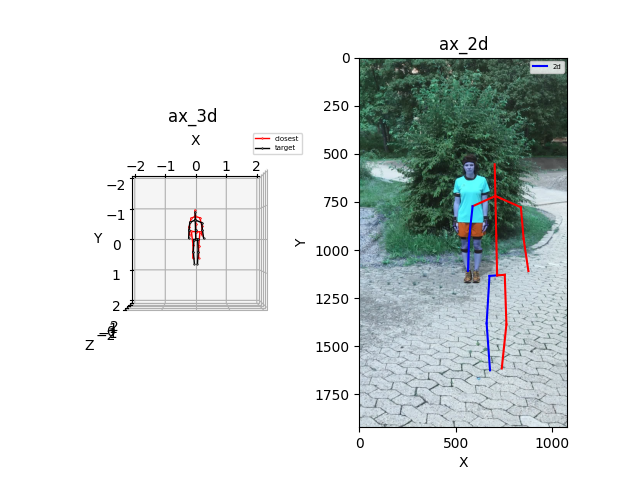

In [32]:
img = cv2.imread(f'{root_3dpw_original}/{img_path[frame_num]}')
configs = {
    'ax_3d': {'type': '3d', 'loc': 121, 'mode': 'cam'},
    'ax_2d': {'type': '2d', 'loc': 122, 'W': W, 'H': H},
}
fig, axs = generate_axes(2, configs, fig_title='')
plot_pose_setting = [
    ('ax_3d', original_3d[None], {'color': 'r', 'label': 'closest', 'dataset': 'h36m_without_nose'}),
    ('ax_3d', closest_pose[None], {'color': 'k', 'label': 'target', 'dataset': 'h36m_without_nose'}),
    ('ax_2d', pose2d_denorm[None], {'color': '', 'label': '2d', 'dataset': 'h36m_without_nose', 'img': img}),
]
general_plot_func(axs, configs, plot_pose_setting, 0)
plt.show()

NameError: name 'pose3d_poseaug' is not defined

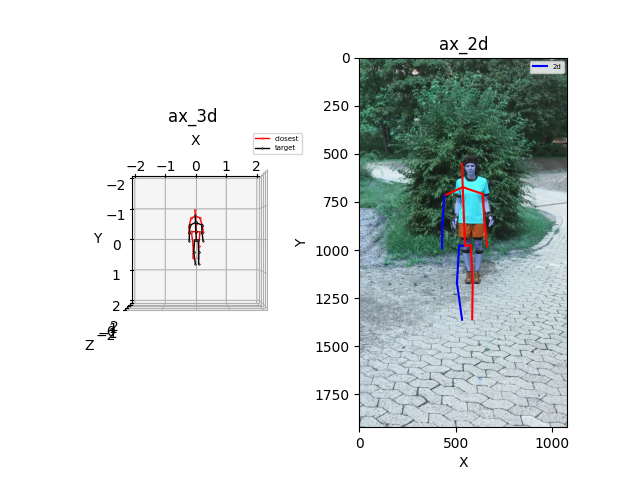

In [43]:
img = cv2.imread(f'{root_3dpw_original}/{closest_img_path}')
configs = {
    'ax_3d': {'type': '3d', 'loc': 121, 'mode': 'cam'},
    'ax_2d': {'type': '2d', 'loc': 122, 'W': W, 'H': H},
}
fig, axs = generate_axes(2, configs, fig_title='')
plot_pose_setting = [
    ('ax_3d', closest_pose[None], {'color': 'r', 'label': 'closest', 'dataset': 'h36m_without_nose'}),
    ('ax_3d', target_pose, {'color': 'k', 'label': 'target', 'dataset': 'h36m_without_nose'}),
    ('ax_2d', pose2d_denorm, {'color': '', 'label': '2d', 'dataset': 'h36m_without_nose', 'img': img}),
]
general_plot_func(axs, configs, plot_pose_setting, frame_num)
plt.show()

In [26]:
img_folder = os.path.join(img_root, seq_name)
assert os.path.exists(img_folder), f'{img_folder} does not exists'
num_frames = len(os.listdir(img_folder))
frame_num = closest_frame
t = cam_extrinsics[frame_num, :3, 3] # (N, 3, 1)
R = cam_extrinsics[frame_num, :3, :3] # (N, 3, 3)
C = -R.T @ t

# load img
img = cv2.imread(glob(img_folder+f'/image_{frame_num:05d}.jpg')[0])
W, H = img.shape[1], img.shape[0]


plot_pose_setting = [
    ('ax_3d_cam', pose3d_poseaug[target_frame][None], {'color': 'k', 'label': '3d', 'dataset': 'h36m_without_nose', 'linestyle': '--'}),
    ('ax_2d_norm', pose2d_poseaug[target_frame][None], {'color': 'k', 'label': '2d', 'dataset': 'h36m_without_nose', 'linestyle': '--'}),
]

num_persons = len(test_data['poses'])
for sub_id in range(num_persons):
    smpl_world_3d = jointPositions[sub_id].reshape(-1, 24, 3)[frame_num]   # 24, 3
    smpl_cam_3d = np.einsum('ij,jk->ik', smpl_world_3d, R) + t
    world_3d = smpl2h36m(smpl_world_3d, with_nose=False)
    cam_3d = smpl2h36m(smpl_cam_3d, with_nose=False)
    img_2d = projection(cam_3d, cam_intrinsics)
    img_2d_norm = normalize_input(img_2d, W, H)
    pose2d_proj = projection(pose3d_poseaug[target_frame], cam_intrinsics)
    pose2d_denorm = denormalize_input(pose2d_poseaug[target_frame], W, H)
    world_3d_from_poseaug = (pose3d_poseaug[target_frame] - t) @ R.T
    
    plot_pose_setting += [
        ('ax_3d_world', world_3d, {'color': '', 'label': '3d', 'dataset': 'h36m_without_nose'}),
        ('ax_3d_world', world_3d_from_poseaug, {'color': 'k', 'label': '3d', 'dataset': 'h36m_without_nose'}),
        ('ax_3d_cam', cam_3d, {'color': '', 'label': '3d', 'dataset': 'h36m_without_nose'}),
        ('ax_2d', img_2d, {'color': '', 'label': '2d', 'dataset': 'h36m_without_nose'}),
        ('ax_2d', pose2d_denorm, {'color': 'k', 'label': '2d', 'dataset': 'h36m_without_nose', 'linestyle': '--'}),
        ('ax_2d', pose2d_proj, {'color': 'y', 'label': '2d', 'dataset': 'h36m_without_nose', 'linestyle': '--'}),
        ('ax_2d_norm', img_2d_norm, {'color': '', 'label': '2d', 'dataset': 'h36m_without_nose', 'normalize': True}),
    ]

configs = {
        'ax_3d_world': {'type': '3d', 'loc': 141, 'mode': 'world', 'zlim': [0, 2], 'xlim': [-4, 4], 'ylim': [-4, 4], 'view': [45, 45]},
        'ax_3d_cam': {'type': '3d', 'loc': 142, 'mode': 'cam'},
        'ax_2d': {'type': '2d', 'loc': 143, 'W': W, 'H': H},
        'ax_2d_norm': {'type': '2d', 'loc': 144, 'normalize': True},
}
fig, axs = generate_axes(0, configs, fig_title='')
plot_pose_setting += [('ax_2d', None, {'img': img})]
axs['ax_3d_world'].scatter(C[0], C[1], C[2], c='r', marker='o')

general_plot_func(axs, configs, plot_pose_setting, 0)
plt.show()

NameError: name 'closest_frame' is not defined